In [7]:
# Importing necessary libraries (NumPy, Pandas, Matplotlib)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter, defaultdict
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc


np.random.seed(42)
random.seed(42)

In [10]:

df = pd.read_csv('dataset/spam.csv', encoding='latin-1')

In [11]:
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())

Dataset shape: (5572, 5)

First 5 rows:
     v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN  


In [12]:
print("\nColumn information:")
print(df.info())


Column information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB
None


In [13]:

print("\nMissing values:")
print(df.isnull().sum())


Missing values:
v1               0
v2               0
Unnamed: 2    5522
Unnamed: 3    5560
Unnamed: 4    5566
dtype: int64


In [14]:

#dropping missing values and finalizing dataset 
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, errors='ignore')
df = df.rename(columns={'v1': 'label', 'v2': 'message'})

print("\nCleaned dataset:")
print(df.head())


Cleaned dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [15]:
# Exploring Dataset
print("\nClass distribution:")
print(df['label'].value_counts())
print(df['label'].value_counts(normalize=True) * 100)


Class distribution:
label
ham     4825
spam     747
Name: count, dtype: int64
label
ham     86.593683
spam    13.406317
Name: proportion, dtype: float64


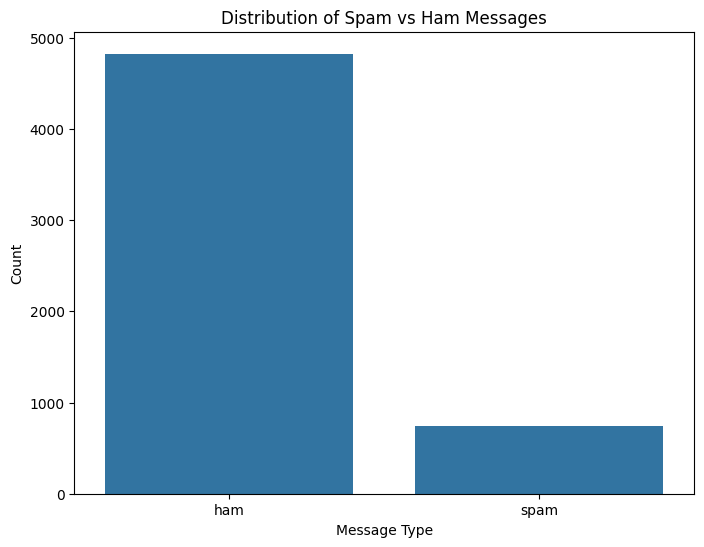

In [16]:
# class chart
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Distribution of Spam vs Ham Messages')
plt.xlabel('Message Type')
plt.ylabel('Count')
plt.show()

In [17]:
# Analyze message lengths
df['length'] = df['message'].apply(len)
print("\nMessage length statistics:")
print(df.groupby('label')['length'].describe())


Message length statistics:
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.023627  58.016023   2.0   33.0   52.0   92.0  910.0
spam    747.0  138.866131  29.183082  13.0  132.5  149.0  157.0  224.0


C:\Users\mcsmu\AppData\Local\Temp\ipykernel_2256\1415111952.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Message Type')


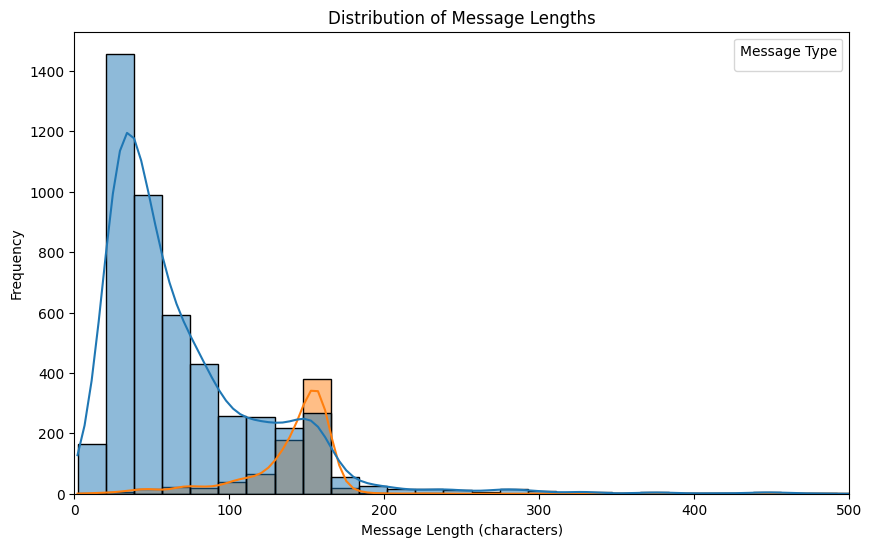

In [18]:
# Visualize message lengths by class
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='length', hue='label', bins=50, kde=True)
plt.title('Distribution of Message Lengths')
plt.xlabel('Message Length (characters)')
plt.ylabel('Frequency')
plt.xlim(0, 500)  # Limit x-axis for better visualization
plt.legend(title='Message Type')
plt.show()